In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("/home/cocopyth/MasterThesis/src/")
from make_dataset import *
from config import *
from model import *
from data_prepare import *
from sklearn.metrics import mean_squared_error, r2_score


2024-07-10 17:30:46.383163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-10 17:30:46.383844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/cocopyth/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-07-10 17:31:29.812052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cocopyth/MasterThesis/ML/lib/python3.9/site-packages/cv2/../../lib64:
2024-07-10 17:31:29.813680: W tensorflow/stream_executor/cuda/cuda_

In [2]:
model_name_list = ["bin2_BO_without_crop_best_model_val_version"]
crop_value = [120,100,80,120,100,80,100]
model_list,learning_rate = load_model_list(model_name_list,model_path)
new_model_list = []
for index in range(len(model_list)):
    config = model_list[index].get_config()
    new_model = keras.Sequential().from_config(config)
    new_model_list.append(new_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

In [3]:
plate_ids = ['20230901_Plate310', '20230902_Plate310', '20230903_Plate310',
       # '20230904_Plate310', '20230905_Plate310'
            ]
def load_datasets_antoine(list_ids):
    Xs = []
    ys = []
    for plate_id in list_ids:
        X_antoine = np.load(f"{plate_id}_feature.npy")
        print(len(X_antoine))
        y_antoine = np.expand_dims(np.load(f"{plate_id}_label.npy"),axis= 1)
        Xs.append(X_antoine)
        ys.append(y_antoine)
    return(np.concatenate(Xs, axis=0),np.concatenate(ys, axis=0))

In [4]:
X_antoine1,y_antoine1 = load_datasets_antoine(plate_ids[:2])
X_antoine2,y_antoine2 = load_datasets_antoine(plate_ids[2:])

76
278
530


In [5]:
X_antoine1,y_antoine1 = load_datasets_antoine(plate_ids[:4])

76
278
530


[5.13661485]


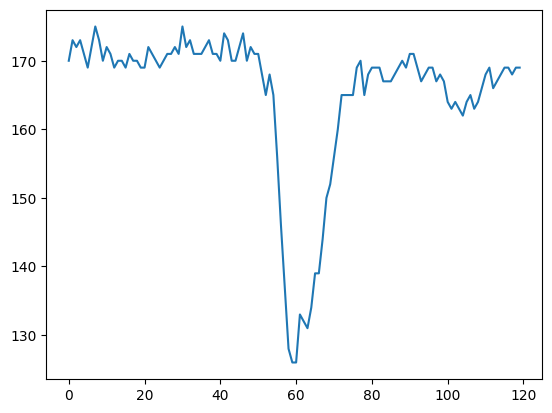

In [22]:
i = np.random.randint(0,len(y_antoine1))
y_antoine1[i]
print(y_antoine1[i])
fig,ax = plt.subplots()
ax.plot(X_antoine1[i])


(array([  2.,  30.,  77., 115., 107., 194., 211., 110.,  28.,  10.]),
 array([1.05238331, 1.48639142, 1.92039954, 2.35440765, 2.78841577,
        3.22242388, 3.65643199, 4.09044011, 4.52444822, 4.95845634,
        5.39246445]),
 <BarContainer object of 10 artists>)

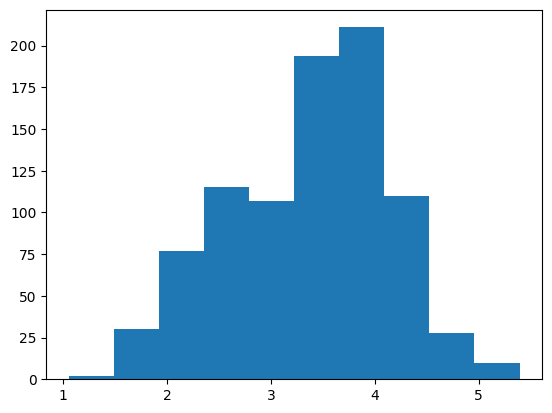

In [9]:
fig,ax = plt.subplots()
ax.hist(y_antoine1.flatten()/2)

Linear Regression RMSE: 0.590618172972564
Linear Regression R²: 0.24462611529876344


Text(0, 0.5, '$r_{predicted}$ ($\\mu m$)')

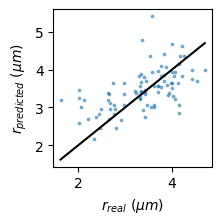

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_antoine1, y_antoine1, test_size=0.1, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_val)

# Calculate metrics
linear_rmse = np.sqrt(mean_squared_error(y_val/2, y_pred_linear/2))
linear_r2 = r2_score(y_val/2, y_pred_linear/2)

print(f"Linear Regression RMSE: {linear_rmse}")
print(f"Linear Regression R²: {linear_r2}")
y_predict = linear_model.predict(X_val)

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(y_val/2,y_predict/2,s=3,alpha = 0.5)
ax.plot([np.min(y_val)/2,np.max(y_val)/2],[np.min(y_val)/2,np.max(y_val)/2],color="black")
ax.set_xlabel('$r_{real}$ ($\mu m$)')
ax.set_ylabel('$r_{predicted}$ ($\mu m$)')

In [5]:
data_list_k = ["20230111_Plate521","20230111_Plate493","20230109_Plate521","20221116_Plate21"]
data_list_f = ["varying_lum_and_focus_train","varying_lum_and_focus_test"]
X_train_k, y_train_k, X_test_k , y_test_k = combine_dataset(data_list_k,2)
X_train_f, y_train_f, X_test_f , y_test_f = combine_dataset(data_list_f,1)
X_train = np.concatenate([X_train_k,X_train_f], axis=0)
X_test  = np.concatenate ([X_test_k ,X_test_f] , axis=0)
y_train = np.concatenate([y_train_k,y_train_f], axis=0)
y_test  = np.concatenate ([y_test_k ,y_test_f] , axis=0)
X = np.concatenate([X_train,X_test,X_antoine1], axis=0)
y = np.concatenate([y_train,y_test,y_antoine1], axis=0)
# X = np.concatenate([X_train,X_test], axis=0)
# y = np.concatenate([y_train,y_test], axis=0)
data_list_test = ["20230113_Plate521"]
X1, y1, X2 , y2 = combine_dataset(data_list_test,2)
# data_list_f = ["varying_lum_and_focus_test"]
# X1, y1, X2 , y2  = combine_dataset(data_list_f,1)

X_test = np.concatenate([X_antoine2,X1,X2], axis=0)
y_test = np.concatenate([y_antoine2,y1,y2], axis=0)
# X_test = np.concatenate([X1,X2], axis=0)
# y_test = np.concatenate([y1,y2], axis=0)
y_test = y_test.reshape(y_test.shape[0],1)

/home/cocopyth/MasterThesis/src/data_prepare.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_list, y_train_list, X_test_list , y_test_list = np.array(X_train_list), np.array(y_train_list), np.array(X_test_list) , np.array(y_test_list)


In [6]:
X = X.astype(np.float64)
y = y.astype(np.float64)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [7]:
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)
len(y)

3341

Text(0, 0.5, 'count')

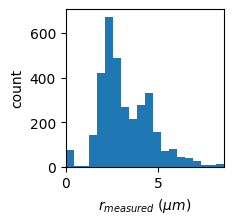

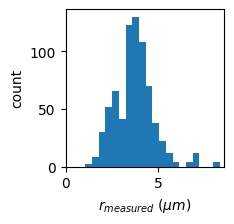

In [8]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.hist(y/2,20)
ax.set_xlim(0,np.max(y/2))
ax.set_xlabel('$r_{measured}$ ($\mu m$)')
ax.set_ylabel('count')
# plt.savefig(os.path.join(path_figure,'train_valid_set_ditrib.pdf'), transparent=True, bbox_inches='tight')

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.hist(y_test/2,20)
ax.set_xlim(0,np.max(y/2))
ax.set_xlabel('$r_{measured}$ ($\mu m$)')
ax.set_ylabel('count')
# plt.savefig(os.path.join(path_figure,'test_set_ditrib.pdf'), transparent=True, bbox_inches='tight')


Text(0, 0.5, 'count')

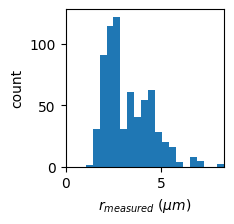

In [9]:
counts, bin_edges = np.histogram(y, bins=20, density=True)
bin_edges[0], bin_edges[-1] = -np.inf, np.inf  # To include all possible values

# 2. Assign each y_test value to a bin
y_test_bin_indices = np.digitize(y_test, bin_edges) - 1

# 3. Calculate the proportion of counts for each bin in y
total_count = np.sum(counts)
proportions = counts / total_count

# 4. Sample from y based on these proportions
resampled_y_test = []
resampled_X_test = []
for i, proportion in enumerate(proportions):
    bin_count = int(proportion * len(y_test))
    bin_indices = np.where(y_test_bin_indices == i)[0]
    if len(bin_indices) > 0:
        chosen_indices = np.random.choice(bin_indices, bin_count, replace=True)
        resampled_y_test.extend(y_test[chosen_indices])
        resampled_X_test.extend(X_test[chosen_indices])

resampled_y_test = np.array(resampled_y_test)
resampled_X_test = np.array(resampled_X_test)

resampled_y_test = np.array(resampled_y_test)
fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.hist(resampled_y_test/2,20)
ax.set_xlim(0,np.max(resampled_y_test/2))
ax.set_xlabel('$r_{measured}$ ($\mu m$)')
ax.set_ylabel('count')
# plt.savefig(os.path.join(path_figure,'test_set_ditrib.pdf'), transparent=True, bbox_inches='tight')


In [10]:
linear_rmse = mean_squared_error(resampled_y_test/2, [np.mean(resampled_y_test)/2]*len(resampled_y_test))
linear_rmse

1.4701584701028498

Linear Regression RMSE: 0.8024588235193718
Linear Regression R²: 0.5619926854558438


Text(0, 0.5, '$r_{predicted}$ ($\\mu m$)')

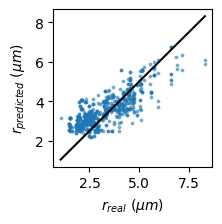

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(resampled_X_test)

# Calculate metrics
linear_rmse = np.sqrt(mean_squared_error(resampled_y_test/2, y_pred_linear/2))
linear_r2 = r2_score(resampled_y_test/2, y_pred_linear/2)

print(f"Linear Regression RMSE: {linear_rmse}")
print(f"Linear Regression R²: {linear_r2}")
y_predict = linear_model.predict(resampled_X_test)

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(resampled_y_test/2,y_predict/2,s=3,alpha = 0.5)
ax.plot([np.min(y_test)/2,np.max(y_test)/2],[np.min(y_test)/2,np.max(y_test)/2],color="black")
ax.set_xlabel('$r_{real}$ ($\mu m$)')
ax.set_ylabel('$r_{predicted}$ ($\mu m$)')

In [12]:
model = new_model_list[0]

In [13]:
for layer in model.layers:
    if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
        layer.kernel_initializer = layer.kernel_initializer
        layer.bias_initializer = layer.bias_initializer

        if hasattr(layer, 'kernel'):
            layer.kernel.assign(layer.kernel_initializer(shape=layer.kernel.shape))
        if hasattr(layer, 'bias'):
            layer.bias.assign(layer.bias_initializer(shape=layer.bias.shape))


In [14]:
model.summary()

# # To get more detailed configuration of each layer
# for layer in model.layers:
#     print(layer.get_config())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

In [16]:
len(X_test),len(y_test)

(726, 726)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
train_feature = X_train
train_label   = y_train**2
val_feature  = X_val
val_label    = y_val**2
learning_rate_value=0.0001
crop_size=120
batch_size=32
epochs=120
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_value),
    loss="mean_squared_error",
    metrics="mean_absolute_error")
history = model.fit(
                x=data_preparation(train_feature,crop_size),
                y=train_label,
                epochs=epochs,
                batch_size=batch_size,
                verbose=1,
                validation_data=(data_preparation(val_feature,crop_size), val_label),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error",min_delta=1e-3,patience=20)])
learning_rate_value=0.00001
crop_size=120
batch_size=128
epochs=120
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_value),
    loss="mean_squared_error",
    metrics="mean_absolute_error")
history = model.fit(
                x=data_preparation(train_feature,crop_size),
                y=train_label,
                epochs=epochs,
                batch_size=batch_size,
                verbose=1,
                validation_data=(data_preparation(val_feature,crop_size), val_label),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error",min_delta=1e-3,patience=10)])
learning_rate_value=0.000001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_value),
    loss="mean_squared_error",
    metrics="mean_absolute_error")
history = model.fit(
                x=data_preparation(train_feature,crop_size),
                y=train_label,
                epochs=epochs,
                batch_size=batch_size,
                verbose=1,
                validation_data=(data_preparation(val_feature,crop_size), val_label),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error",min_delta=1e-3,patience=10)])

Epoch 1/120
94/94 [==============================] - 8s 71ms/step - loss: 1434.6051 - mean_absolute_error: 24.9464 - val_loss: 3626.3750 - val_mean_absolute_error: 44.0525
Epoch 2/120
94/94 [==============================] - 7s 71ms/step - loss: 787.9048 - mean_absolute_error: 18.7646 - val_loss: 3268.1067 - val_mean_absolute_error: 41.2822
Epoch 3/120
94/94 [==============================] - 7s 70ms/step - loss: 694.2212 - mean_absolute_error: 17.5332 - val_loss: 2854.6917 - val_mean_absolute_error: 37.7067
Epoch 4/120
94/94 [==============================] - 6s 68ms/step - loss: 639.9557 - mean_absolute_error: 16.7216 - val_loss: 2359.4797 - val_mean_absolute_error: 33.1723
Epoch 5/120
94/94 [==============================] - 6s 68ms/step - loss: 605.8947 - mean_absolute_error: 16.0820 - val_loss: 1594.5032 - val_mean_absolute_error: 25.7697
Epoch 6/120
94/94 [==============================] - 6s 69ms/step - loss: 575.1125 - mean_absolute_error: 15.6950 - val_loss: 1012.1894 - val_me

In [18]:
plt.style.use('presentation.mplstyle')

y_predict = np.sqrt(model.predict(X_test))
y_predict2 = np.sqrt(model.predict(X))
y_predict3 = np.sqrt(model.predict(X_val))
for A in [y_predict,y_predict2,y_predict3]:
    A[np.isnan(A)] = 0

/tmp/ipykernel_5340/597065071.py:4: RuntimeWarning: invalid value encountered in sqrt
  y_predict2 = np.sqrt(model.predict(X))
/tmp/ipykernel_5340/597065071.py:5: RuntimeWarning: invalid value encountered in sqrt
  y_predict3 = np.sqrt(model.predict(X_val))


In [19]:
# y_test = np.sqrt(y_test)
# y_val = np.sqrt(y_val)

Group 1: RMSE = 1.0607136938195123
Group 2: RMSE = 0.48591677792065335
Group 3: RMSE = 0.8473649695154096
Group 4: RMSE = 0.8674584834414131
Group 5: RMSE = 0.3726487332770772
Group 6: RMSE = 0.4935285386856907
Group 7: RMSE = 0.6218112509557864
Group 8: RMSE = 0.8525804549068143


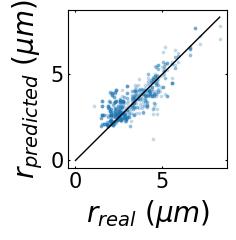

In [20]:
y_predict4 = np.sqrt(model.predict(resampled_X_test))
y_predict4[np.isnan(y_predict4)] = 10
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(resampled_y_test/2,y_predict4/2,s=3,alpha = 0.2)
ax.plot([0,np.max(resampled_y_test)/2],[0,np.max(resampled_y_test)/2],color="black")
ax.set_xlabel('$r_{real}$ ($\mu m$)',fontsize = 20)
ax.set_ylabel('$r_{predicted}$ ($\mu m$)',fontsize = 20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# plt.savefig(os.path.join(path_figure,'pred_GT.pdf'), transparent=True, bbox_inches='tight')

import numpy as np

# Assuming resampled_y_test and y_predict4 are defined as numpy arrays

# Step 1: Determine the min and max of the predicted values to create intervals
min_pred = np.min(y_predict4)
max_pred = np.max(y_predict4)
intervals = np.linspace(min_pred, max_pred, 9)  # Creates 6 intervals

# Step 2 & 3: Assign to groups and compute RMSE for each group
group_rmse = []
for i in range(8):
    # Identify the indices of the predictions that fall into the current interval
    indices = np.where((y_predict4 >= intervals[i]) & (y_predict4 < intervals[i+1]))[0]
    # Extract the real and predicted values for these indices
    real_values = resampled_y_test[indices]
    predicted_values = y_predict4[indices]
    # Compute RMSE for this group
    rmse = np.sqrt(np.mean((real_values - predicted_values) ** 2))
    group_rmse.append(rmse)

# group_rmse now contains the RMSE for each of the 6 groups

# Optionally, print or return the RMSE values
for i, rmse in enumerate(group_rmse, 1):
    print(f"Group {i}: RMSE = {rmse/2}")
# plt.savefig(os.path.join(path_figure,'pred_test.pdf'), transparent=True, bbox_inches='tight')


In [21]:
intervals

array([ 2.44393921,  4.08468568,  5.72543216,  7.36617863,  9.00692511,
       10.64767158, 12.28841805, 13.92916453, 15.569911  ])

In [22]:
np.save("intervals",intervals)
np.save("rmses",group_rmse)

Text(0, 0.5, '$r_{predicted}$ ($\\mu m$)')

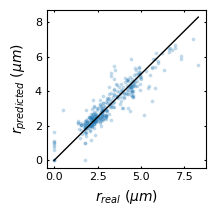

In [23]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(y_val/2,y_predict3/2,s=3,alpha = 0.2)

ax.plot([0,np.max(y_test)/2],[0,np.max(y_test)/2],color="black")
ax.set_xlabel('$r_{real}$ ($\mu m$)')
ax.set_ylabel('$r_{predicted}$ ($\mu m$)')
# ax.set_xlim()
# ax.set_ylim()
# plt.savefig(os.path.join(path_figure,'pred_GT.pdf'), transparent=True, bbox_inches='tight')


Text(0, 0.5, '$r_{predicted}$ ($\\mu m$)')

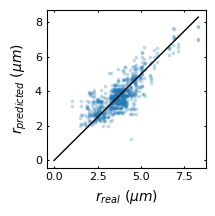

In [24]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(y_test/2,y_predict/2,s=3,alpha = 0.2)
ax.plot([0,np.max(y_test)/2],[0,np.max(y_test)/2],color="black")
ax.set_xlabel('$r_{real}$ ($\mu m$)')
ax.set_ylabel('$r_{predicted}$ ($\mu m$)')
# ax.set_xlim()
# ax.set_ylim()
# plt.savefig(os.path.join(path_figure,'pred_GT.pdf'), transparent=True, bbox_inches='tight')


2.13653132190183
3.204796982852745
4.27306264380366
5.341328304754574
6.409593965705489
7.477859626656405


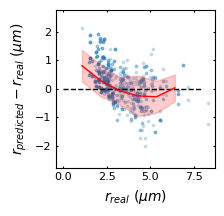

In [25]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(resampled_y_test/2,y_predict4/2-resampled_y_test/2,s=3,alpha = 0.2)
ax.hlines(0,0,8,color="black",linestyle="dashed")

ax.set_xlabel('$r_{real}$ ($\mu m$)')
ax.set_ylabel('$r_{predicted}-r_{real}$ ($\mu m$)')
# ax.set_xlim()
ax.set_ylim(-1*np.std(y),1*np.std(y))
residuals = y_predict4/2 - resampled_y_test/2
n=8

# New code for evenly spaced groups
min_y_test, max_y_test = np.min(y)/2, np.max(y)/2
interval_length = (max_y_test - min_y_test) / n
group_means = []
group_stds = []  # For uncertainties

for i in range(n):
    start = min_y_test + i * interval_length
    end = start + interval_length
    indices = np.where((resampled_y_test/2 >= start) & (resampled_y_test/2 < end))
    if len(indices[0])>2:
        # mean_y_test = np.nanmean(y_test[indices] / 2)
        mean_residual = np.nanmean(residuals[indices])
        mean_y_test = (start+end)/2
        mean_y_test = start
        
        std_residual = np.nanstd(residuals[indices])  # Standard deviation for uncertainty
        group_means.append((mean_y_test, mean_residual))
        group_stds.append(std_residual)
        print(end)
    # break
group_means = np.array(group_means)
# Plotting the mean
ax.plot(group_means[:,0], group_means[:,1], color="red", label='Mean Residual')

# Adding shaded uncertainty areas
ax.fill_between(group_means[:,0],group_means[:,1] - group_stds, group_means[:,1] + group_stds, 
                     color='red', alpha=0.2)
# plt.savefig(os.path.join(path_figure,'residuals.pdf'), transparent=True, bbox_inches='tight')


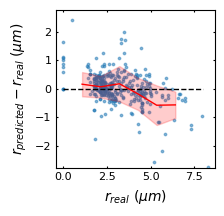

In [26]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (5.2*cm,5.2*cm))
ax.scatter(y_val/2,y_predict3/2-y_val/2,s=3,alpha = 0.5)
ax.hlines(0,0,8,color="black",linestyle="dashed")

ax.set_xlabel('$r_{real}$ ($\mu m$)')
ax.set_ylabel('$r_{predicted}-r_{real}$ ($\mu m$)')
# ax.set_xlim()
ax.set_ylim(-np.std(y),np.std(y))
residuals = y_predict3/2 - y_val/2

# New code for evenly spaced groups
min_y_test, max_y_test = np.min(y)/2, np.max(y)/2
n=8
interval_length = (max_y_test - min_y_test) / n
group_means = []
group_stds = []  # For uncertainties

for i in range(n):
    start = min_y_test + i * interval_length
    end = start + interval_length
    indices = np.where((y_val/2 >= start) & (y_val/2 < end))
    if start>0 and len(indices[0])>2:
    
        # mean_y_test = np.mean(y_val[indices] / 2)
        mean_residual = np.nanmean(residuals[indices])
        std_residual = np.nanstd(residuals[indices])  # Standard deviation for uncertainty
        mean_y_test = (start+end)/2
        mean_y_test = start

        group_means.append((mean_y_test, mean_residual))
        group_stds.append(std_residual)

group_means = np.array(group_means)
# Plotting the mean
ax.plot(group_means[:,0], group_means[:,1], color="red", label='Mean Residual')

# Adding shaded uncertainty areas
ax.fill_between(group_means[:,0],group_means[:,1] - group_stds, group_means[:,1] + group_stds, 
                     color='red', alpha=0.2)
# plt.savefig(os.path.join(path_figure,'residuals_train.pdf'), transparent=True, bbox_inches='tight')


In [27]:
1e3*3e-3*2*np.pi*3*24

1357.1680263507906

In [28]:
y_predict = np.sqrt(model.predict(X_val))
y_predict[np.isnan(y_predict)] = np.nanmean(y_predict)
mse = mean_squared_error(y_val/2, y_predict/2)
np.sqrt(mse),r2_score(y_val, y_predict)

/tmp/ipykernel_5340/1549269936.py:1: RuntimeWarning: invalid value encountered in sqrt
  y_predict = np.sqrt(model.predict(X_val))


(0.6573058348026408, 0.7891734746954766)

In [29]:
y_predict = np.sqrt(model.predict(X_test))
y_predict[np.isnan(y_predict)] = np.nanmean(y_predict)
mse = mean_squared_error(y_test/2, y_predict/2)
np.sqrt(mse),r2_score(y_test, y_predict)

(0.6420153689548425, 0.6294715266164717)

In [30]:
y_predict = np.sqrt(model.predict(resampled_X_test))
y_predict[np.isnan(y_predict)] = np.nanmean(y_predict)
# y_predict[np.isnan(y_predict)] = 0

mse = mean_squared_error(resampled_y_test/2, y_predict/2)
np.sqrt(mse),r2_score(resampled_y_test, y_predict)

(0.7043335642897236, 0.6602714878183189)

In [31]:
# model.save(r'C:\Users\coren\Documents\PhD\Code\AMFtrack\amftrack\ml\models\model_quadratic.h5')

In [32]:
zegijebije

NameError: name 'zegijebije' is not defined

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K


# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_rmse = []
fold_r2 = []

for train_index, test_index in kf.split(X):
    # Splitting data into training and validation sets for the current fold
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    train_feature = X_train
    train_label   = y_train
    val_feature  = X_val
    val_label    = y_val
    # Assuming model and data_preparation are defined as per your code
    # Resetting the model might be necessary depending on your setup
    model = new_model_list[0]
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel_initializer = layer.kernel_initializer
            layer.bias_initializer = layer.bias_initializer

        if hasattr(layer, 'kernel'):
            layer.kernel.assign(layer.kernel_initializer(shape=layer.kernel.shape))
        if hasattr(layer, 'bias'):
            layer.bias.assign(layer.bias_initializer(shape=layer.bias.shape))

    train_scheme(model,train_feature,train_label,val_feature,val_label)
    # Evaluate the model
    y_pred = model.predict(data_preparation(X_val, crop_size))
    fold_rmse.append(np.sqrt(mean_squared_error(y_val/2, y_pred/2)))
    fold_r2.append(r2_score(y_val/2, y_pred/2))

# Calculate average metrics over all folds
average_rmse = np.mean(fold_rmse)
average_r2 = np.mean(fold_r2)

print(f"Average RMSE over {n_splits} folds: {average_rmse}")
print(f"Average R2 over {n_splits} folds: {average_r2}")


In [ ]:
print(f"Average RMSE over {n_splits} folds: {average_rmse}")
print(f"Average R2 over {n_splits} folds: {average_r2}")

In [ ]:
def train_scheme(model,train_feature,train_label,val_feature,val_label):
    learning_rate_value=0.0001
    crop_size=120
    batch_size=32
    epochs=120
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_value),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    history = model.fit(
                    x=data_preparation(train_feature,crop_size),
                    y=train_label,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(data_preparation(val_feature,crop_size), val_label),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error",min_delta=1e-3,patience=20)])
    learning_rate_value=0.00001
    crop_size=120
    batch_size=32
    epochs=120
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_value),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    history = model.fit(
                    x=data_preparation(train_feature,crop_size),
                    y=train_label,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(data_preparation(val_feature,crop_size), val_label),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error",min_delta=1e-3,patience=10)])
    learning_rate_value=0.000001
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_value),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    history = model.fit(
                    x=data_preparation(train_feature,crop_size),
                    y=train_label,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(data_preparation(val_feature,crop_size), val_label),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error",min_delta=1e-3,patience=10)])
